# First version of AE with clustering loss

## Import useful modules

In [1]:
!pip install scanpy
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip3 install igraph
!pip3 install leidenalg
!pip install os
!pip install csv

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement csv (from versions: none

In [2]:
from keras import layers
from keras.layers import Layer
from keras.models import load_model, Model
from keras import backend as K
from keras.losses import KLDivergence
import numpy as np
import scanpy as sc
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from layers import ConstantDispersionLayer, SliceLayer, ColWiseMultLayer
import keras
from keras.layers import Layer
from sklearn.model_selection import train_test_split
import datetime
import time
import os
import csv
from scipy.optimize import linear_sum_assignment as linear_assignment

2024-07-08 10:52:54.343817: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 10:53:01.754752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.__version__

'2.16.1'

In [4]:
keras.__version__

'3.3.3'

## Preprocessing

### Load dataset

On importe le dataset baron et on applique le prétraitement habituel

In [5]:
filename="./dataset/barondata_rawcounts.csv"
data_baron=pd.read_csv(filename, sep=';', comment="#", index_col=0)
data_baron

,human1_lib1.final_cell_0001,human1_lib1.final_cell_0002,human1_lib1.final_cell_0003,human1_lib1.final_cell_0004,human1_lib1.final_cell_0005,human1_lib1.final_cell_0006,human1_lib1.final_cell_0007,human1_lib1.final_cell_0008,human1_lib1.final_cell_0009,human1_lib1.final_cell_0010,...,human4_lib3.final_cell_0692,human4_lib3.final_cell_0693,human4_lib3.final_cell_0694,human4_lib3.final_cell_0695,human4_lib3.final_cell_0696,human4_lib3.final_cell_0697,human4_lib3.final_cell_0698,human4_lib3.final_cell_0699,human4_lib3.final_cell_0700,human4_lib3.final_cell_0701
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,4,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A4GALT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,0,1,0,1,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
ZYX,2,4,0,3,1,1,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
ZZEF1,0,0,0,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
ZZZ3,0,1,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [6]:
filename="./dataset/barondata_annotations.csv"
annotations_baron=pd.read_csv(filename, sep=';', comment="#", index_col=0)
annotations_baron

,donor,label
human1_lib1.final_cell_0001,GSM2230757,acinar
human1_lib1.final_cell_0002,GSM2230757,acinar
human1_lib1.final_cell_0003,GSM2230757,acinar
human1_lib1.final_cell_0004,GSM2230757,acinar
human1_lib1.final_cell_0005,GSM2230757,acinar
...,...,...
human4_lib3.final_cell_0697,GSM2230760,activated_stellate
human4_lib3.final_cell_0698,GSM2230760,alpha
human4_lib3.final_cell_0699,GSM2230760,beta
human4_lib3.final_cell_0700,GSM2230760,beta


In [7]:
data_ann=sc.AnnData(data_baron.T)
data_ann

AnnData object with n_obs × n_vars = 8569 × 20125

In [8]:
data_ann.obs['label'] = annotations_baron['label']

### Filter data

On filtre les données de manière peu stricte

In [9]:
sc.pp.filter_cells(data_ann, min_genes=1)
sc.pp.filter_genes(data_ann, min_cells=1)

In [10]:
data_ann.raw = data_ann.copy()

In [11]:
data_ann

AnnData object with n_obs × n_vars = 8569 × 17499
    obs: 'label', 'n_genes'
    var: 'n_cells'

### Normalize and scale

In [12]:
sc.pp.normalize_total(data_ann)
data_ann.obs['size_factors'] = data_ann.obs.n_genes / np.median(data_ann.obs.n_genes)
#data_ann.obs['size_factors'] = 1.0
sc.pp.log1p(data_ann)


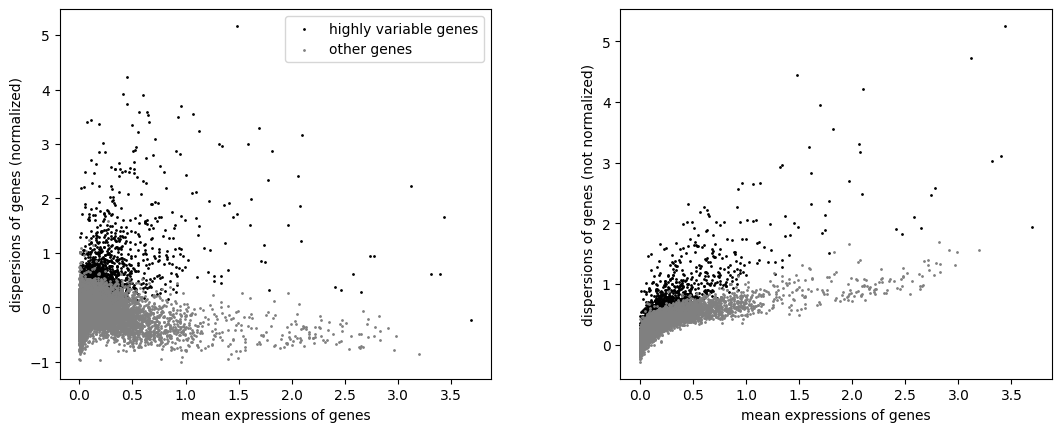

In [13]:
sc.pp.highly_variable_genes(data_ann, n_top_genes=2000, batch_key="label")
sc.pl.highly_variable_genes(data_ann)

In [14]:
sc.pp.scale(data_ann)

### Explore the result

In [15]:
data_ann.X

array([[-0.06469017,  1.563252  , -0.1655249 , ..., -0.37393612,
        -0.3080396 ,  0.31848672],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
         0.37840593, -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       ...,
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617]], dtype=float32)

In [16]:
data_ann.n_vars

17499

In [17]:
data_ann.X

array([[-0.06469017,  1.563252  , -0.1655249 , ..., -0.37393612,
        -0.3080396 ,  0.31848672],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
         0.37840593, -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       ...,
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617]], dtype=float32)

In [18]:
data_ann.var

,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mean,std
A1BG,42,False,0.011018,-0.025517,-0.574290,1,False,0.003199,0.049455
A1CF,1408,False,0.140704,0.230606,-0.024027,1,False,0.132453,0.327797
A2M,273,False,0.162812,0.371500,0.196539,3,False,0.029914,0.180720
A4GALT,444,False,0.134773,0.333580,0.060687,3,False,0.043716,0.203291
AAAS,1216,True,0.183781,0.576148,0.473154,6,False,0.104913,0.285008
...,...,...,...,...,...,...,...,...,...
ZYG11B,1394,False,0.192391,0.371347,-0.082705,1,False,0.119749,0.299532
ZYX,2691,False,0.572281,0.582603,-0.147203,2,False,0.289623,0.489316
ZZEF1,1225,False,0.144169,0.421400,0.217033,2,False,0.106196,0.283994
ZZZ3,872,False,0.120500,0.381103,0.083912,1,False,0.074865,0.243036


In [19]:
data_ann.obs

,label,n_genes,size_factors
human1_lib1.final_cell_0001,acinar,3526,1.909042
human1_lib1.final_cell_0002,acinar,4201,2.274499
human1_lib1.final_cell_0003,acinar,2119,1.147266
human1_lib1.final_cell_0004,acinar,2956,1.600433
human1_lib1.final_cell_0005,acinar,2715,1.469951
...,...,...,...
human4_lib3.final_cell_0697,activated_stellate,1055,0.571197
human4_lib3.final_cell_0698,alpha,1007,0.545208
human4_lib3.final_cell_0699,beta,942,0.510016
human4_lib3.final_cell_0700,beta,1031,0.558202


In [20]:
data_ann.raw.X

array([[0, 4, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
highly_variable_genes = data_ann.var[data_ann.var['highly_variable']].index.tolist()
count_data_hvg = data_ann[:, highly_variable_genes].X
count_data_hvg=count_data_hvg.toarray()
count_data_hvg

array([[-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 ,  0.31848672],
       [-0.36810586,  0.04432194, -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       [-0.36810586,  0.3338874 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       ...,
       [-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       [-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       [-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617]], dtype=float32)

In [22]:
raw_count_hvg=data_ann.raw[:,highly_variable_genes].X

## Create autoencoder

In [23]:
def negative_binomial_loss(y_true, y_pred):
    input_shape=int(y_pred.shape[1]/3)
    mu = y_pred[:, :input_shape]
    pi = y_pred[:, input_shape:input_shape*2]
    theta = y_pred[:, input_shape*2:]
    y_true = tf.cast(y_true, dtype='float32')
    #print(type(mu), mu)
    #print(type(pi),pi)
    #print(type(theta), theta)
    #print(type(y_true), y_true)


    eps = 1e-10
    t1 = tf.math.lgamma(theta+eps) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+eps)
    t2 = (theta+y_true) * tf.math.log(1.0 + (mu/(theta+eps))) + (y_true * (tf.math.log(theta+eps) - tf.math.log(mu+eps)))
    final=t1 + t2
    final = tf.reduce_mean(final)
    return final

def zero_inflated_negative_binomial_loss(y_true, y_pred):
    input_shape=int(y_pred.shape[1]/3)
    mu = y_pred[:, :input_shape]
    pi = y_pred[:, input_shape:input_shape*2]
    theta = y_pred[:, input_shape*2:]
    y_true = tf.cast(y_true, dtype='float32')
    #print(type(mu), mu)
    #print(type(pi),pi)
    #print(type(theta), theta)
    #print(type(y_true), y_true)


    eps = 1e-10
    t1 = tf.math.lgamma(theta+eps) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+eps)
    t2 = (theta+y_true) * tf.math.log(1.0 + (mu/(theta+eps))) + (y_true * (tf.math.log(theta+eps) - tf.math.log(mu+eps)))
    final=t1 + t2

    nb_case = t1 + t2 - tf.math.log(1.0-pi+eps)
    zero_nb = tf.pow(theta/(theta+mu+eps), theta)
    zero_case = -tf.math.log(pi + ((1.0-pi)*zero_nb)+eps)
    result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
    #ridge = self.ridge_lambda*tf.square(self.pi)
    #result += ridge
    result = tf.reduce_mean(result)
    return result

MeanAct = lambda x: tf.clip_by_value(tf.keras.backend.exp(x), 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.keras.backend.softplus(x), 1e-4, 1e4)

ColWiseMultLayer = lambda name: layers.Lambda(lambda l: l[0]*(tf.matmul(tf.reshape(l[1], (-1,1)),
                                                                 tf.ones((1, l[0].get_shape()[1]),
                                                                         dtype=l[1].dtype))), name=name)

In [24]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters=n_clusters
        self.alpha=alpha
        self.intial_weights=weights
        #self.input_spec=keras.InputSpec(ndim=2) #to specify the expected rank of the input

    def build(self, input_shape):
        input_dim=input_shape[1]
        #self.input_spec=keras.InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform')
        if self.intial_weights is not None :
            self.set_weights(self.intial_weights)
            del self.intial_weights
        self.built=True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (tf.math.reduce_sum(tf.math.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = tf.transpose(tf.transpose(q) / tf.math.reduce_sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [25]:
def create_autoencoder(input_shape, noise):
    init='glorot_uniform'
    Inputs = layers.Input(shape=(input_shape,), name='Inputs')
    sf_layer=layers.Input(shape=(1,), name="size_factors")
    x=layers.GaussianNoise(noise)(Inputs)
    x=layers.Dense(256, activation='relu',kernel_initializer=init, name='encoder_1' )(x)
    x=layers.GaussianNoise(noise)(x)
    x=layers.Dense(64, activation='relu',kernel_initializer=init, name='encoder_2' )(x)
    x=layers.GaussianNoise(noise)(x)
    hidden=layers.Dense(32, activation='relu',kernel_initializer=init, name='encoder_3' )(x)


    x=layers.Dense(32, activation='relu',kernel_initializer=init, name='decoder_1' )(hidden)
    x=layers.Dense(64, activation='relu',kernel_initializer=init, name='decoder_2' )(x)
    x=layers.Dense(256, activation='relu',kernel_initializer=init, name='decoder_3' )(x)
    pi=layers.Dense(input_shape, activation="sigmoid",kernel_initializer=init, name='pi')(x)
    disp=layers.Dense(input_shape, activation=DispAct,kernel_initializer=init, name='dispersion')(x)
    mean=layers.Dense(input_shape, activation=MeanAct,kernel_initializer=init, name='mean')(x)

    Outputs=ColWiseMultLayer(name='outputs')([mean, sf_layer])
    #Outputs=SliceLayer(0, name='slice')([Outputs, disp, pi])
    outputs = layers.Concatenate(axis=1, name='output')([Outputs, pi, disp])

    autoencoder=Model([Inputs, sf_layer], outputs, name='autoencoder_ZINB')
    autoencoder.compile(optimizer='adam', loss={'output': zero_inflated_negative_binomial_loss})

    autoencoder.summary()
    return autoencoder

In [26]:
input_shape=data_ann.n_vars
input_shape

17499

In [27]:
data_ann.X.shape[1]

17499

In [28]:
np.shape(data_ann.X)
data_ann

AnnData object with n_obs × n_vars = 8569 × 17499
    obs: 'label', 'n_genes', 'size_factors'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg'

On entraîne le modèle sur l'ensemble des données

In [29]:
def display_latent_space(y_pred, model, count_data_hvg , size_factors, obs):
    encoder= Model(inputs=model.input, outputs=model.get_layer("encoder_3").output)
    encoder.summary()
    predict_data=encoder.predict([count_data_hvg, size_factors])
    adata_latent = sc.AnnData(predict_data)
    adata_latent.obs=obs
    adata_latent.obs['predict']=y_pred
    anno=adata_latent.obs['label']
    sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    sc.pl.umap(adata_latent, color="label")
    sc.pl.umap(adata_latent, color="predict")
    crosstab = pd.crosstab(y_pred,anno)
    sns.heatmap(crosstab, annot=True, cmap='Blues')
    plt.ylabel('Clusters prédits')
    plt.xlabel('Annotations réelles')
    plt.title('Matrice de confusion')
    plt.show()

In [30]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = np.asarray(y_true)
   
    y_pred = np.asarray(y_pred)
    
    # Assurez-vous que les étiquettes sont de type str
    y_true= y_true.astype(str)
    y_pred = y_pred.astype(str)
    
    # Trouver les étiquettes uniques
    labels = np.unique(np.concatenate((y_true, y_pred)))
    n_labels = len(labels)

    # Construire la matrice de coût (matrice de confusion)
    cost_matrix = np.zeros((n_labels, n_labels), dtype=int)
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            cost_matrix[i, j] = np.sum((y_true == label_true) & (y_pred == label_pred))

    # Résoudre le problème de correspondance bipartite optimal
    row_ind, col_ind = linear_assignment(cost_matrix.max() - cost_matrix)

    # Calculer la précision
    accuracy = np.sum([cost_matrix[i, j] for i, j in zip(row_ind, col_ind)]) / y_true.size

    return accuracy


In [31]:
def save_results_to_csv(history, filename):
    file_exists = os.path.isfile(filename)
    with open(filename, mode='a') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(history.keys())
        writer.writerow(history.values())
        
def check_existing_filename(filename):
    base, ext = os.path.splitext(filename)
    counter = 1
    while os.path.exists(filename):
        filename = f"{base}_{counter}{ext}"
        counter += 1
    return filename

def save_plot_umap(model, x, size_factors, y, y_pred, res, iteration, pdf_pages, train_test="train"):
    #Récupération des données et projection dans l'espace latent 
    encoder= Model(inputs=model.input, outputs=model.get_layer("encoder_3").output)
    predict_data=encoder.predict([x, size_factors], verbose=0)
    obs_df = pd.DataFrame({'label': y})
    
    #Préparation des données pour Scanpy
    adata_latent = sc.AnnData(X=predict_data)
    adata_latent.obs = obs_df
    adata_latent.obs['predict'] = y_pred.astype(str)

    sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    
    # Génération du UMAP avec Scanpy
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata_latent, color='label', ax=axs[0], show=False)
    axs[0].set_title(f'UMAP projection - Labels ({train_test}) (Res: {res}, Iter: {iteration})')
    sc.pl.umap(adata_latent, color='predict', ax=axs[1], show=False)
    axs[1].set_title(f'UMAP projection - Predictions ({train_test}) (Res: {res}, Iter: {iteration})')
    

    pdf_pages.savefig(fig)
    plt.close(fig)

### Essayons de trouver une bonne valeur de gamma

In [32]:
def target_distribution(q):
    weight = q**2/q.sum(0)
    return (weight.T/weight.sum(1)).T

def auto_kmeans(encoder, x_counts, size_factors, obs, plot=False):
    y=obs["label"]
    ari=[]
    nmi=[]
    x=[]
    for n in range (1,20):
        kmeans=KMeans(n_clusters=n, n_init=30, verbose=0)
        y_pred=kmeans.fit_predict(encoder.predict([x_counts, size_factors]))
        ari.append(adjusted_rand_score(y, y_pred))
        nmi.append(normalized_mutual_info_score(y, y_pred))
        x.append(n)
    somme_metriques = [x + y for x, y in zip(ari, nmi)]
    n_max=(somme_metriques.index(max(somme_metriques))+1)
    
    kmeans=KMeans(n_clusters=n_max, n_init=20)
    y_pred=kmeans.fit_predict(encoder.predict([x_counts, size_factors]))
    
    if plot==True:
        predict_data=encoder.predict([x_counts, size_factors])
        adata_latent = sc.AnnData(predict_data)
        adata_latent.obs=obs
        adata_latent.obs["kmeans"]=y_pred
        sc.pp.neighbors(adata_latent)
        sc.tl.umap(adata_latent)
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,ari)
        plt.xlabel("nombre de clusters")
        plt.ylabel("ARI")
        plt.plot(x,nmi)
        plt.xlabel("nombre de clusters")
        plt.ylabel("NMI")
        ari = adjusted_rand_score(y, y_pred)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, y_pred)
        print("Normalized mutual info (NMI) :", nmi)
        sc.pl.umap( adata_latent, color=["kmeans"], legend_loc="on data")
        plt.plot()
    return y_pred, n_max, kmeans.cluster_centers_

def auto_leiden(encoder, x_counts, size_factors, y, res="auto", plot=False):
    predict_data=encoder.predict([x_counts, size_factors], verbose=0)
    adata_latent = sc.AnnData(predict_data)
    obs_df = pd.DataFrame({'label': y})
    adata_latent.obs=obs_df
    sc.pp.neighbors(adata_latent, use_rep='X')
    sc.tl.umap(adata_latent)
    list_ari=[]
    list_nmi=[]
    list_ca=[]
    x=[]
    
    if res=="auto":
        #search for the best resolution
        for i in range (1,10):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/100)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            list_ca.append(cluster_acc(y, predict_cluster))
            x.append(i/100)
        for i in range (1,11):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/10)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            list_ca.append(cluster_acc(y, predict_cluster))
            x.append(i/10)
        somme_metriques = [x + y + z for x, y, z in zip(list_ari, list_nmi, list_ca)]
        res=x[somme_metriques.index(max(somme_metriques))]
        print("La résolution est de : ", res)
    #compute for the best resolution
    sc.tl.leiden(adata_latent, key_added="leiden_res_%.4f" % (res), resolution=res)
    predict=adata_latent.obs["leiden_res_%.4f" % (res)]
    
    
    #compute cluster center for initialization
    init_pred=np.asarray(predict,dtype=int)
    features=pd.DataFrame(adata_latent.X,index=np.arange(0,adata_latent.shape[0]))
    Group=pd.Series(init_pred,index=np.arange(0,adata_latent.shape[0]),name="Group")
    Mergefeature=pd.concat([features,Group],axis=1)
    cluster_centers=np.asarray(Mergefeature.groupby("Group").mean())
    n_clusters=len(np.unique(init_pred))
    
    #set of plot if required
    if plot==True:
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,list_ari)
        plt.plot(x,list_nmi)
        plt.plot(x,list_ca)
        plt.xlabel("nombre de clusters")
        plt.ylabel("Score")
        plt.legend(labels=["ARI", "NMI", "CA"])
        sc.pl.umap( adata_latent, color=["leiden_res_%.4f" % (res)], legend_loc="on data")
        ari = adjusted_rand_score(y, predict)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, predict)
        print("Normalized mutual info (NMI) :", nmi)
        ca=cluster_acc(y, predict_cluster)
        print("Clustering accuracy (CA) :", ca)
        plt.plot()
        #crosstab = pd.crosstab(predict,y)
        #sns.heatmap(crosstab, annot=True, cmap='Blues')
        #plt.ylabel('Clusters prédits')
        #plt.xlabel('Annotations réelles')
        #plt.title('Matrice de confusion')
        #plt.show()
    return res, predict, n_clusters, cluster_centers
    
def split(x_counts, raw_counts, size_factors, y):
    train_idx, temp_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
    x_train=x_counts[train_idx]
    x_val=x_counts[val_idx]
    size_factors_train=size_factors[train_idx]
    size_factors_val=size_factors[val_idx]
    raw_train=raw_counts[train_idx]
    raw_val=raw_counts[val_idx]
    y_train=y[train_idx]
    y_val=y[val_idx]
    print("Size of train set : ", x_train.shape)
    print("Size of test set : ", x_val.shape)
    return x_train, x_val, size_factors_train, size_factors_val, raw_train, raw_val, y_train, y_val
    
def fit_and_split(x_counts, obs, size_factors, raw_counts, alpha, n_cluster="auto", res="auto", method="leiden", noise=0.5, batch_size=256,
        max_iter=2e4, tol=1e-3, update_interval=140, loss_weights=[1,1],
        ae_weights=None, pretrained=False):
    print('Update interval', update_interval)
    t0 = time.time()
    y=obs["label"]
    #step 0 split data
    x_train, x_test, size_factors_train, size_factors_test, raw_train, raw_test, y_train, y_test=split(x_counts, raw_counts, size_factors, y)
    input_shape=x_train.shape[1]
    #Step 1 Pretrain 
    if pretrained==False or ae_weights is None :
        print("..pretraining autoencoder : ")
        autoencoder=create_autoencoder(input_shape, noise)
        callback= tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode='min', verbose=1)
        autoencoder.fit(x=[x_train, size_factors_train], y=raw_train, validation_data=([x_test,size_factors_test], raw_test), batch_size=batch_size, epochs=200, callbacks=[callback])
        autoencoder.save_weights("./model/weights/pbmc_weight_ae.weights.h5")
        ae_weights="./model/weights/pbmc_weight_ae.weights.h5"
    elif ae_weights is not None:
            autoencoder=create_autoencoder(input_shape, noise)
            autoencoder.load_weights(ae_weights)
            print('ae_weights is loaded successfully.')
    
    ae_layers = [l for l in autoencoder.layers]
    hidden = autoencoder.input[0]
    for i in range(1, len(ae_layers)):
        if "noise" in ae_layers[i].name:
            next
        elif "dropout" in ae_layers[i].name:
            next
        else:
            hidden = ae_layers[i](hidden)
        if "encoder_3" in ae_layers[i].name:  # only get encoder layers
             break
    encoder = Model(inputs=autoencoder.input, outputs=hidden, name='encoder')
    encoder.summary()

    
    #step 2 intialize clusters:
    
    #récupérons l'autoencoder
    #encoder= Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("hidden").output)
    if method=="leiden":
        print("Initializing cluster centers with leiden : ")
        res, y_pred, n_cluster, cluster_centers = auto_leiden(encoder, x_train, size_factors_train, y_train, res=res, plot=False)
        print('Le nombre de clusters est : ', n_cluster)
    elif method=="kmeans":
        print("Initializing cluster centers with k-means : ")
        if n_cluster=="auto":
            y_pred, n_cluster, cluster_centers=auto_kmeans(encoder, x_train, size_factors_train, obs, plot=False)
            print('Le nombre de clusters est : ', n_cluster)
        else :
            kmeans=KMeans(n_clusters=n_cluster, n_init=20)
            y_pred=kmeans.fit_predict(encoder.predict([x_train, size_factors]))
            cluster_centers=kmeans.cluster_centers_
        
    y_pred_last_train=np.copy(y_pred)
    
    clustering_layer = ClusteringLayer(n_cluster, alpha=alpha, name='clustering')(hidden)
    model= Model(inputs=[autoencoder.input[0], autoencoder.input[1]],
                           outputs=[clustering_layer, autoencoder.output])
    model.summary()
    model.compile(loss={'clustering': KLDivergence, 'output': zero_inflated_negative_binomial_loss}, optimizer='adam',loss_weights={'clustering': loss_weights[0], 'output': loss_weights[1]}, metrics={'clustering': KLDivergence, 'output': zero_inflated_negative_binomial_loss})
    print("Set clustering weights")
    model.get_layer(name='clustering').set_weights([cluster_centers])
    print("Done")
    
    #step 3 deep clustering
    print("..Starting Deep Clustering")
    loss=[0,0,0]
    val_loss=[0,0,0]
    index=0
    save_interval = int(x_counts.shape[0] / batch_size) * 5 
    
    #Création du dictionnaire pour le monitoring
    history={
        "res":res,
        "clusters": n_cluster,
        "weight": loss_weights[0],
        "NMI" :[],
        "ARI" :[],
        "CA" :[],
        "val_NMI":[],
        "val_ARI":[],
        "val_CA":[],
        "loss":[],
        "val_loss":[],
        "clustering_loss":[],
        "val_clustering_loss":[],
        "zinb_loss":[],
        "val_zinb_loss":[]
    }
        
    #initiate pdf files
    pdf_filename_train = 'data/weight_test/plots/pbmc/all_pbmc_plots_train_weight_%.4f.pdf' % loss_weights[0]
    #pdf_filename_train = check_existing_filename(pdf_filename_train)
    pdf_pages_train = PdfPages(pdf_filename_train)
    
    pdf_filename_test = 'data/weight_test/plots/pbmc/all_pbmc_plots_test_weight_%.4f.pdf' % loss_weights[0]
    #pdf_filename_test = check_existing_filename(pdf_filename_test)
    pdf_pages_test = PdfPages(pdf_filename_test)
    
    for iteration in range(int(max_iter)):
       
        #if iteration % update_interval==0:
        
        if index==0:
            q_train,_= model.predict([x_train, size_factors_train], verbose=0)
            p_train=target_distribution(q_train)
            q_test,_= model.predict([x_test, size_factors_test], verbose=0)
            p_test=target_distribution(q_test)
            
            loss=model.evaluate(x=[x_train, size_factors_train], y=[p_train, raw_train], batch_size=batch_size, verbose=0)
            val_loss=model.evaluate(x=[x_test, size_factors_test], y=[p_test, raw_test], batch_size=batch_size, verbose=0)
            
            y_pred_train=q_train.argmax(1)
            y_pred_test=q_test.argmax(1)
            if y is not None :
                ca=np.round(cluster_acc(y_train, y_pred_train), 5)
                nmi=np.round(normalized_mutual_info_score(y_train, y_pred_train), 5)
                ari=np.round(adjusted_rand_score(y_train, y_pred_train), 5)
                val_ca=np.round(cluster_acc(y_test, y_pred_test), 5)
                val_nmi=np.round(normalized_mutual_info_score(y_test, y_pred_test), 5)
                val_ari=np.round(adjusted_rand_score(y_test, y_pred_test), 5)
                print('Iter-%d: CA=%.4f, NMI= %.4f, ARI= %.4f; L= %.5f, Lc= %.5f,  Lr= %.5f'
                          % (iteration, ca, nmi, ari, loss[0], loss[1], loss[2]))
                print('CA=%.4f, val_NMI= %.4f, val_ARI= %.4f; val_L= %.5f, val_Lc= %.5f,  val_Lr= %.5f'
                          % (val_ca, val_nmi, val_ari, val_loss[0], val_loss[1], val_loss[2]))
          
                #maj du dictionnaire 
                history["CA"].append(ca)
                history["NMI"].append(nmi)
                history["ARI"].append(ari)
                history["val_CA"].append(val_ca)
                history["val_NMI"].append(val_nmi)
                history["val_ARI"].append(val_ari)
                history["loss"].append(loss[0])
                history["clustering_loss"].append(loss[1])
                history["zinb_loss"].append(loss[2])
                history["val_loss"].append(val_loss[0])
                history["val_clustering_loss"].append(val_loss[1])
                history["val_zinb_loss"].append(val_loss[2])
                
                if iteration==0:
                    history['CA_initial']=ca
                    history['ARI_initial']=ari
                    history['NMI_initial']=nmi
                    history['val_CA_initial']=val_ca
                    history['val_ARI_initial']=val_ari
                    history['val_NMI_initial']=val_nmi
                    
            
            #save a plot
            save_plot_umap(model, x_train, size_factors_train, y_train, y_pred_train, res, iteration, pdf_pages_train, "train")
            save_plot_umap(model, x_test, size_factors_test, y_test, y_pred_test, res, iteration, pdf_pages_test, "test")


                
            #stop criterion
            delta_label=np.sum(y_pred_train != y_pred_last_train).astype(np.float32)/y_pred_train.shape[0]
            y_pred_last_train=np.copy(y_pred_train)
            if iteration >0 and delta_label<tol:
                print('delta_label ', delta_label, '< tol ', tol)
                print('Reached tolerance threshold. Stopping training.')
                break
    
        if (index + 1)*batch_size > x_train.shape[0]:
            model.train_on_batch(x=[x_train[index * batch_size::], size_factors_train[index * batch_size:]],
                                                 y=[p_train[index * batch_size::], raw_train[index * batch_size::]])
            index=0
        else:
            model.train_on_batch(x=[x_train[index * batch_size:(index + 1) * batch_size], 
                                                    size_factors_train[index * batch_size:(index + 1) * batch_size]],
                                                 y=[p_train[index * batch_size:(index + 1) * batch_size],
                                                    raw_train[index * batch_size:(index + 1) * batch_size]])
            index += 1
        
        #if iteration % save_interval == 0:
            # save scDeepCluster model checkpoints
            #print('saving model to: ''/weights' + str(iteration) + '.h5')
            #model.save_weights('/weights' + str(iteration) + '.h5')
            #print('saving model to: model/weights.weights.h5')
            #model.save_weights('model/weights.weights.h5')
    
        #iteration+=1
    
    ca = np.round(cluster_acc(y_train, y_pred_train), 5)
    nmi = np.round(normalized_mutual_info_score(y_train, y_pred_train), 5)
    ari = np.round(adjusted_rand_score(y_train, y_pred_train), 5)
    val_ca = np.round(cluster_acc(y_test, y_pred_test), 5)
    val_nmi = np.round(normalized_mutual_info_score(y_test, y_pred_test), 5)
    val_ari = np.round(adjusted_rand_score(y_test, y_pred_test), 5)
    print('Final: CA=%.4f, NMI= %.4f, ARI= %.4f' % (ca, nmi, ari))
    print('Final: val_CA=%.4f, val_NMI= %.4f, val_ARI= %.4f' % (val_ca, val_nmi, val_ari))
    duration=int(time.time() - t0)
    print('Clustering time: %d seconds.' % duration )
    history["training_time"]=duration
    history["nbr_iteration"]=iteration
    history['CA_final']=ca
    history['ARI_final']=ari
    history['NMI_final']=nmi
    history['val_CA_final']=val_ca
    history['val_ARI_final']=val_ari
    history['val_NMI_final']=val_nmi
                    
    
    #save dictionnary
    save_results_to_csv(history, "data/weight_test/weight_diff_AE_clustering_loss_val.csv")
    
    pdf_pages_train.close()
    pdf_pages_test.close()
    
    return y_pred, model

In [33]:
for w in [50.0,20.0,10.0,5.0,2.0,1.0,0.5,0.2,0.1,0.05,0.02] : 
    y_pred, model=fit_and_split(count_data_hvg, data_ann.obs,  data_ann.obs.size_factors, raw_count_hvg, method="leiden", alpha=1.0, noise=1, n_cluster="auto", batch_size=256,
             max_iter=5e3, tol=1e-3, update_interval=27, loss_weights=[w,1.0],
            pretrained=False)

Update interval 27


/tmp/ipykernel_52455/2420813251.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_52455/2420813251.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_52455/2420813251.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_2    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - loss: 0.8349 - val_loss: 0.5971
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - loss: 0.5735 - val_loss: 0.5604
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - loss: 0.5536 - val_loss: 0.5493
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - loss: 0.5435 - val_loss: 0.5423
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - loss: 0.5337 - val_loss: 0.5375
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step - loss: 0.5289 - val_loss: 0.5341
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - loss: 0.5249 - val_loss: 0.5319
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - loss: 0.5233 - val_loss: 0.5292
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - loss: 0.5213 - val_loss: 0.5267
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - loss: 0.5169 - val_loss: 0.5250
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - loss: 0.5145 - val_loss: 0.5241
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 


/tmp/ipykernel_52455/2420813251.py:59: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/100)


La résolution est de :  0.08
Le nombre de clusters est :  6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise[0… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_2    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8838, NMI= 0.8651, ARI= 0.9159; L= 9.36497, Lc= 0.17759,  Lr= 0.48535
CA=0.8802, val_NMI= 0.8494, val_ARI= 0.9047; val_L= 9.47789, val_Lc= 0.18037,  val_Lr= 0.51822
Iter-24: CA=0.8811, NMI= 0.8640, ARI= 0.9104; L= 8.05514, Lc= 0.15122,  Lr= 0.49438
CA=0.8731, val_NMI= 0.8463, val_ARI= 0.8928; val_L= 7.88242, val_Lc= 0.14606,  val_Lr= 0.51925
Iter-48: CA=0.8803, NMI= 0.8631, ARI= 0.9100; L= 4.63491, Lc= 0.08257,  Lr= 0.50918
CA=0.8755, val_NMI= 0.8518, val_ARI= 0.8993; val_L= 5.17043, val_Lc= 0.09459,  val_Lr= 0.52678
Iter-72: CA=0.8791, NMI= 0.8612, ARI= 0.9073; L= 3.13186, Lc= 0.05211,  Lr= 0.51886
CA=0.8770, val_NMI= 0.8577, val_ARI= 0.9042; val_L= 4.19191, val_Lc= 0.07849,  val_Lr= 0.53218
Iter-96: CA=0.8783, NMI= 0.8599, ARI= 0.9059; L= 2.97162, Lc= 0.04867,  Lr= 0.52237
CA=0.8778, val_NMI= 0.8593, val_ARI= 0.9069; val_L= 3.86399, val_Lc= 0.07434,  val_Lr= 0.53396
Iter-120: CA=0.8776, NMI= 0.8585, ARI= 0.9041; L= 2

/tmp/ipykernel_52455/2420813251.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_52455/2420813251.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_52455/2420813251.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_52455/2420813251.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_52455/2420813251.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_3    │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_4    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_5    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - loss: 0.8541 - val_loss: 0.6056
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - loss: 0.5773 - val_loss: 0.5658
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.5541 - val_loss: 0.5541
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - loss: 0.5464 - val_loss: 0.5459
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.5365 - val_loss: 0.5393
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 0.5341 - val_loss: 0.5358
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.5278 - val_loss: 0.5336
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - loss: 0.5233 - val_loss: 0.5304
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - loss: 0.5242 - val_loss: 0.5280
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.5217 - val_loss: 0.5279
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - loss: 0.5173 - val_loss: 0.5251
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━

/tmp/ipykernel_52455/2420813251.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_52455/2420813251.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_52455/2420813251.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_52455/2420813251.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_52455/2420813251.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_12   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_13   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_14   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - loss: 0.8153 - val_loss: 0.6092
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - loss: 0.5819 - val_loss: 0.5652
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - loss: 0.5524 - val_loss: 0.5496
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - loss: 0.5414 - val_loss: 0.5422
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - loss: 0.5344 - val_loss: 0.5384
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 0.5283 - val_loss: 0.5344
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - loss: 0.5251 - val_loss: 0.5320
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.5293 - val_loss: 0.5293
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 0.5176 - val_loss: 0.5281
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5222 - val_loss: 0.5257
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 0.5182 - val_loss: 0.5235
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
La résolution est de :  0.06
Le nombre de clusters est :  7


Model: "functional_165"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_12   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_13   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_14   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 7)         │        224 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,816 (7.98 MB)

 Trainable params: 2,092,816 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8830, NMI= 0.8670, ARI= 0.9107; L= 0.84860, Lc= 0.18224,  Lr= 0.48449
CA=0.8802, val_NMI= 0.8461, val_ARI= 0.8944; val_L= 0.88257, val_Lc= 0.18122,  val_Lr= 0.51728
Iter-24: CA=0.8810, NMI= 0.8651, ARI= 0.9054; L= 0.81384, Lc= 0.16072,  Lr= 0.49271
CA=0.8786, val_NMI= 0.8572, val_ARI= 0.8988; val_L= 0.83205, val_Lc= 0.15682,  val_Lr= 0.51787
Iter-48: CA=0.8806, NMI= 0.8639, ARI= 0.9047; L= 0.69512, Lc= 0.09562,  Lr= 0.50450
CA=0.8794, val_NMI= 0.8599, val_ARI= 0.9002; val_L= 0.73470, val_Lc= 0.11185,  val_Lr= 0.52302
Iter-72: CA=0.8795, NMI= 0.8620, ARI= 0.9025; L= 0.64117, Lc= 0.06541,  Lr= 0.51059
CA=0.8786, val_NMI= 0.8585, val_ARI= 0.8982; val_L= 0.70333, val_Lc= 0.09678,  val_Lr= 0.52673
Iter-96: CA=0.8793, NMI= 0.8633, ARI= 0.9024; L= 0.62421, Lc= 0.05424,  Lr= 0.51563
CA=0.8817, val_NMI= 0.8638, val_ARI= 0.9054; val_L= 0.68684, val_Lc= 0.08659,  val_Lr= 0.53082
Iter-120: CA=0.8793, NMI= 0.8644, ARI= 0.9020; L= 0

/tmp/ipykernel_52455/2420813251.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_52455/2420813251.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_52455/2420813251.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_52455/2420813251.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_52455/2420813251.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_15   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_16   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_17   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - loss: 0.8796 - val_loss: 0.6094
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - loss: 0.5865 - val_loss: 0.5635
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - loss: 0.5529 - val_loss: 0.5516
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - loss: 0.5473 - val_loss: 0.5441
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 0.5399 - val_loss: 0.5389
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5333 - val_loss: 0.5355
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 0.5316 - val_loss: 0.5316
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.5274 - val_loss: 0.5289
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.5170 - val_loss: 0.5262
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 0.5195 - val_loss: 0.5245
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5166 - val_loss: 0.5221
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
La résolution est de :  0.07
Le nombre de clusters est :  7


Model: "functional_207"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_15   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_16   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_17   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_1… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 7)         │        224 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,816 (7.98 MB)

 Trainable params: 2,092,816 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8838, NMI= 0.8717, ARI= 0.9151; L= 0.67961, Lc= 0.19423,  Lr= 0.48568
CA=0.8825, val_NMI= 0.8575, val_ARI= 0.9058; val_L= 0.70835, val_Lc= 0.19359,  val_Lr= 0.51781
Iter-24: CA=0.8850, NMI= 0.8762, ARI= 0.9179; L= 0.64619, Lc= 0.15289,  Lr= 0.49373
CA=0.8825, val_NMI= 0.8609, val_ARI= 0.9081; val_L= 0.66553, val_Lc= 0.15008,  val_Lr= 0.51899
Iter-48: CA=0.8841, NMI= 0.8736, ARI= 0.9156; L= 0.58599, Lc= 0.08242,  Lr= 0.50401
CA=0.8833, val_NMI= 0.8655, val_ARI= 0.9120; val_L= 0.61446, val_Lc= 0.10004,  val_Lr= 0.52341
Iter-72: CA=0.8840, NMI= 0.8727, ARI= 0.9159; L= 0.56042, Lc= 0.05230,  Lr= 0.50834
CA=0.8825, val_NMI= 0.8639, val_ARI= 0.9110; val_L= 0.59829, val_Lc= 0.08354,  val_Lr= 0.52522
Iter-96: CA=0.8830, NMI= 0.8714, ARI= 0.9134; L= 0.55582, Lc= 0.04625,  Lr= 0.50959
CA=0.8833, val_NMI= 0.8655, val_ARI= 0.9120; val_L= 0.59706, val_Lc= 0.08088,  val_Lr= 0.52560
Iter-120: CA=0.8816, NMI= 0.8704, ARI= 0.9112; L= 0

/tmp/ipykernel_52455/2420813251.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_52455/2420813251.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_52455/2420813251.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_52455/2420813251.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_52455/2420813251.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_18   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_19   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_20   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - loss: 0.8536 - val_loss: 0.6030
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5789 - val_loss: 0.5621
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5503 - val_loss: 0.5476
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5424 - val_loss: 0.5419
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.5343 - val_loss: 0.5385
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 0.5314 - val_loss: 0.5359
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.5282 - val_loss: 0.5329
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - loss: 0.5238 - val_loss: 0.5300
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - loss: 0.5232 - val_loss: 0.5272
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.5207 - val_loss: 0.5264
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.5175 - val_loss: 0.5253
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
La résolution est de :  0.07
Le nombre de clusters est :  7


Model: "functional_253"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_18   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_1… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_19   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_1… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_20   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 7)         │        224 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,816 (7.98 MB)

 Trainable params: 2,092,816 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8845, NMI= 0.8640, ARI= 0.9119; L= 0.58011, Lc= 0.18659,  Lr= 0.48711
CA=0.8848, val_NMI= 0.8617, val_ARI= 0.9110; val_L= 0.60658, val_Lc= 0.18342,  val_Lr= 0.51831
Iter-24: CA=0.8846, NMI= 0.8734, ARI= 0.9139; L= 0.56685, Lc= 0.14744,  Lr= 0.49349
CA=0.8848, val_NMI= 0.8672, val_ARI= 0.9106; val_L= 0.58753, val_Lc= 0.14406,  val_Lr= 0.51911
Iter-48: CA=0.8830, NMI= 0.8700, ARI= 0.9096; L= 0.54501, Lc= 0.08786,  Lr= 0.50141
CA=0.8825, val_NMI= 0.8660, val_ARI= 0.9083; val_L= 0.56694, val_Lc= 0.10044,  val_Lr= 0.52236
Iter-72: CA=0.8826, NMI= 0.8708, ARI= 0.9091; L= 0.53333, Lc= 0.06022,  Lr= 0.50342
CA=0.8841, val_NMI= 0.8704, val_ARI= 0.9117; val_L= 0.55774, val_Lc= 0.08596,  val_Lr= 0.52223
Iter-96: CA=0.8805, NMI= 0.8678, ARI= 0.9048; L= 0.53280, Lc= 0.05432,  Lr= 0.50574
CA=0.8848, val_NMI= 0.8716, val_ARI= 0.9136; val_L= 0.55688, val_Lc= 0.08363,  val_Lr= 0.52417
Iter-120: CA=0.8786, NMI= 0.8640, ARI= 0.9010; L= 0

/tmp/ipykernel_52455/2420813251.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_52455/2420813251.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_52455/2420813251.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_52455/2420813251.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_52455/2420813251.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_21   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_22   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_23   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - loss: 0.8357 - val_loss: 0.5943
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 0.5687 - val_loss: 0.5612
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 0.5511 - val_loss: 0.5493
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 0.5433 - val_loss: 0.5417
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.5329 - val_loss: 0.5374
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.5274 - val_loss: 0.5345
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.5295 - val_loss: 0.5318
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.5233 - val_loss: 0.5292
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.5218 - val_loss: 0.5279
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.5207 - val_loss: 0.5262
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - loss: 0.5173 - val_loss: 0.5247
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
La résolution est de :  0.07
Le nombre de clusters est :  6


Model: "functional_299"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_21   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_2… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_22   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_2… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_23   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8790, NMI= 0.8643, ARI= 0.9134; L= 0.51864, Lc= 0.18153,  Lr= 0.48265
CA=0.8755, val_NMI= 0.8535, val_ARI= 0.9041; val_L= 0.55081, val_Lc= 0.18231,  val_Lr= 0.51916
Iter-24: CA=0.8806, NMI= 0.8680, ARI= 0.9169; L= 0.52034, Lc= 0.16876,  Lr= 0.48692
CA=0.8763, val_NMI= 0.8548, val_ARI= 0.9055; val_L= 0.54582, val_Lc= 0.16210,  val_Lr= 0.51742
Iter-48: CA=0.8821, NMI= 0.8716, ARI= 0.9196; L= 0.51459, Lc= 0.11693,  Lr= 0.49147
CA=0.8794, val_NMI= 0.8629, val_ARI= 0.9120; val_L= 0.53732, val_Lc= 0.11869,  val_Lr= 0.51770
Iter-72: CA=0.8811, NMI= 0.8697, ARI= 0.9172; L= 0.50957, Lc= 0.08258,  Lr= 0.49327
CA=0.8786, val_NMI= 0.8613, val_ARI= 0.9110; val_L= 0.53171, val_Lc= 0.09390,  val_Lr= 0.51694
Iter-96: CA=0.8803, NMI= 0.8679, ARI= 0.9152; L= 0.50841, Lc= 0.06863,  Lr= 0.49486
CA=0.8802, val_NMI= 0.8651, val_ARI= 0.9126; val_L= 0.53139, val_Lc= 0.08709,  val_Lr= 0.51854
delta_label  0.0008336112037345782 < tol  0.001
Rea

/tmp/ipykernel_52455/2420813251.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_52455/2420813251.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_52455/2420813251.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_52455/2420813251.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_52455/2420813251.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_24   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_25   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_26   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - loss: 0.8283 - val_loss: 0.5977
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - loss: 0.5747 - val_loss: 0.5650
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - loss: 0.5533 - val_loss: 0.5549
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - loss: 0.5459 - val_loss: 0.5455
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5405 - val_loss: 0.5393
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - loss: 0.5315 - val_loss: 0.5360
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 0.5302 - val_loss: 0.5338
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.5267 - val_loss: 0.5318
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.5233 - val_loss: 0.5296
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5197 - val_loss: 0.5277
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.5201 - val_loss: 0.5251
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
La résolution est de :  0.05
Le nombre de clusters est :  6


Model: "functional_321"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_24   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_2… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_25   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_2… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_26   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8686, NMI= 0.8409, ARI= 0.8880; L= 0.50514, Lc= 0.17878,  Lr= 0.48760
CA=0.8661, val_NMI= 0.8271, val_ARI= 0.8819; val_L= 0.53070, val_Lc= 0.17623,  val_Lr= 0.51710
Iter-24: CA=0.8738, NMI= 0.8533, ARI= 0.9003; L= 0.50609, Lc= 0.17084,  Lr= 0.48937
CA=0.8708, val_NMI= 0.8390, val_ARI= 0.8928; val_L= 0.52872, val_Lc= 0.16227,  val_Lr= 0.51614
Iter-48: CA=0.8751, NMI= 0.8571, ARI= 0.9041; L= 0.50505, Lc= 0.13822,  Lr= 0.49151
CA=0.8708, val_NMI= 0.8453, val_ARI= 0.8962; val_L= 0.52634, val_Lc= 0.13245,  val_Lr= 0.51690
Iter-72: CA=0.8753, NMI= 0.8596, ARI= 0.9060; L= 0.50389, Lc= 0.11224,  Lr= 0.49291
CA=0.8708, val_NMI= 0.8466, val_ARI= 0.8970; val_L= 0.52477, val_Lc= 0.11346,  val_Lr= 0.51724
Iter-96: CA=0.8741, NMI= 0.8589, ARI= 0.9039; L= 0.50371, Lc= 0.09760,  Lr= 0.49415
CA=0.8731, val_NMI= 0.8505, val_ARI= 0.9010; val_L= 0.52461, val_Lc= 0.10406,  val_Lr= 0.51803
Iter-120: CA=0.8738, NMI= 0.8576, ARI= 0.9026; L= 0

/tmp/ipykernel_52455/2420813251.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_52455/2420813251.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_52455/2420813251.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_27   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_28   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_29   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 0.8608 - val_loss: 0.6061
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - loss: 0.5803 - val_loss: 0.5631
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - loss: 0.5519 - val_loss: 0.5496
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - loss: 0.5393 - val_loss: 0.5422
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5324 - val_loss: 0.5380
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5319 - val_loss: 0.5346
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5308 - val_loss: 0.5325
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 0.5244 - val_loss: 0.5285
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5221 - val_loss: 0.5276
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.5212 - val_loss: 0.5256
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - loss: 0.5163 - val_loss: 0.5238
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
La résolution est de :  0.05
Le nombre de clusters est :  7


Model: "functional_355"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_27   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_2… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_28   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_2… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_29   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_2… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 7)         │        224 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,816 (7.98 MB)

 Trainable params: 2,092,816 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8901, NMI= 0.8767, ARI= 0.9249; L= 0.49550, Lc= 0.18584,  Lr= 0.48651
CA=0.8895, val_NMI= 0.8697, val_ARI= 0.9210; val_L= 0.52257, val_Lc= 0.18267,  val_Lr= 0.51692
Iter-24: CA=0.8911, NMI= 0.8842, ARI= 0.9281; L= 0.49703, Lc= 0.19080,  Lr= 0.48783
CA=0.8841, val_NMI= 0.8588, val_ARI= 0.9090; val_L= 0.52238, val_Lc= 0.18311,  val_Lr= 0.51650
Iter-48: CA=0.8911, NMI= 0.8855, ARI= 0.9295; L= 0.49707, Lc= 0.17567,  Lr= 0.48853
CA=0.8864, val_NMI= 0.8659, val_ARI= 0.9123; val_L= 0.52175, val_Lc= 0.16870,  val_Lr= 0.51680
Iter-72: CA=0.8911, NMI= 0.8852, ARI= 0.9288; L= 0.49690, Lc= 0.15917,  Lr= 0.48916
CA=0.8872, val_NMI= 0.8689, val_ARI= 0.9142; val_L= 0.52114, val_Lc= 0.15483,  val_Lr= 0.51682
Iter-96: CA=0.8911, NMI= 0.8854, ARI= 0.9293; L= 0.49605, Lc= 0.14532,  Lr= 0.48896
CA=0.8848, val_NMI= 0.8659, val_ARI= 0.9112; val_L= 0.52025, val_Lc= 0.14427,  val_Lr= 0.51639
Iter-120: CA=0.8905, NMI= 0.8845, ARI= 0.9286; L= 0

/tmp/ipykernel_52455/2420813251.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_52455/2420813251.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_52455/2420813251.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_52455/2420813251.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_52455/2420813251.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_30   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_31   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_32   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - loss: 0.8297 - val_loss: 0.6050
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - loss: 0.5771 - val_loss: 0.5636
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.5529 - val_loss: 0.5532
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.5430 - val_loss: 0.5434
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.5355 - val_loss: 0.5376
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - loss: 0.5311 - val_loss: 0.5344
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.5272 - val_loss: 0.5311
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.5243 - val_loss: 0.5286
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.5232 - val_loss: 0.5267
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.5180 - val_loss: 0.5253
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.5156 - val_loss: 0.5235
Epoch 12/200
24/24 ━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
La résolution est de :  0.06
Le nombre de clusters est :  7


Model: "functional_397"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_30   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_31   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_3… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_32   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_3… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 7)         │        224 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,816 (7.98 MB)

 Trainable params: 2,092,816 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8855, NMI= 0.8639, ARI= 0.9111; L= 0.49150, Lc= 0.18714,  Lr= 0.48807
CA=0.8841, val_NMI= 0.8533, val_ARI= 0.9048; val_L= 0.51665, val_Lc= 0.18624,  val_Lr= 0.51731
Iter-24: CA=0.8868, NMI= 0.8662, ARI= 0.9135; L= 0.49172, Lc= 0.19223,  Lr= 0.48824
CA=0.8864, val_NMI= 0.8626, val_ARI= 0.9113; val_L= 0.51610, val_Lc= 0.18864,  val_Lr= 0.51682
Iter-48: CA=0.8868, NMI= 0.8681, ARI= 0.9148; L= 0.49134, Lc= 0.19048,  Lr= 0.48781
CA=0.8864, val_NMI= 0.8640, val_ARI= 0.9117; val_L= 0.51584, val_Lc= 0.18566,  val_Lr= 0.51645
Iter-72: CA=0.8871, NMI= 0.8716, ARI= 0.9172; L= 0.49153, Lc= 0.18754,  Lr= 0.48801
CA=0.8872, val_NMI= 0.8683, val_ARI= 0.9147; val_L= 0.51646, val_Lc= 0.18288,  val_Lr= 0.51789
Iter-96: CA=0.8865, NMI= 0.8714, ARI= 0.9174; L= 0.49082, Lc= 0.18402,  Lr= 0.48733
CA=0.8856, val_NMI= 0.8682, val_ARI= 0.9151; val_L= 0.51590, val_Lc= 0.17812,  val_Lr= 0.51699
Iter-120: CA=0.8870, NMI= 0.8727, ARI= 0.9182; L= 0

In [34]:
for i in range (5): 
    y_pred, model=fit_and_split(count_data_hvg, data_ann.obs,  data_ann.obs.size_factors, raw_count_hvg, method="leiden", alpha=1.0, noise=1, n_cluster="auto", batch_size=256,
             max_iter=5e3, tol=1e-3, update_interval=27, loss_weights=[0.01,1.0],
            pretrained=False)

Update interval 27


/tmp/ipykernel_52455/2420813251.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_52455/2420813251.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_52455/2420813251.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_val=size_factors[val_

Size of train set :  (5998, 2000)
Size of test set :  (1285, 2000)
..pretraining autoencoder : 


/tmp/ipykernel_52455/2420813251.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_52455/2420813251.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_33   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_34   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_35   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,592 (7.98 MB)

 Trainable params: 2,092,592 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - loss: 0.8523 - val_loss: 0.6057
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - loss: 0.5782 - val_loss: 0.5649
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - loss: 0.5546 - val_loss: 0.5504
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - loss: 0.5407 - val_loss: 0.5427
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 0.5337 - val_loss: 0.5379
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - loss: 0.5299 - val_loss: 0.5344
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 0.5277 - val_loss: 0.5312
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - loss: 0.5245 - val_loss: 0.5292
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.5232 - val_loss: 0.5269
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - loss: 0.5172 - val_loss: 0.5263
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - loss: 0.5176 - val_loss: 0.5239
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 530,784 (2.02 MB)

 Trainable params: 530,784 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
La résolution est de :  0.05
Le nombre de clusters est :  6


Model: "functional_451"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 2000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_33   │ (None, 2000)      │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │    512,256 │ gaussian_noise_3… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_34   │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_3… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_35   │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_3… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 2000)      │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 2000)      │    514,000 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 6)         │        192 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 6000)      │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,092,784 (7.98 MB)

 Trainable params: 2,092,784 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: CA=0.8716, NMI= 0.8487, ARI= 0.8976; L= 0.48710, Lc= 0.17800,  Lr= 0.48558
CA=0.8708, val_NMI= 0.8413, val_ARI= 0.8921; val_L= 0.51498, val_Lc= 0.17544,  val_Lr= 0.51684
Iter-24: CA=0.8753, NMI= 0.8550, ARI= 0.9046; L= 0.48735, Lc= 0.18138,  Lr= 0.48584
CA=0.8724, val_NMI= 0.8433, val_ARI= 0.8968; val_L= 0.51542, val_Lc= 0.17689,  val_Lr= 0.51711
Iter-48: CA=0.8741, NMI= 0.8551, ARI= 0.9027; L= 0.48663, Lc= 0.18263,  Lr= 0.48501
CA=0.8716, val_NMI= 0.8438, val_ARI= 0.8956; val_L= 0.51526, val_Lc= 0.17744,  val_Lr= 0.51711
Iter-72: CA=0.8755, NMI= 0.8577, ARI= 0.9056; L= 0.48654, Lc= 0.18316,  Lr= 0.48487
CA=0.8739, val_NMI= 0.8479, val_ARI= 0.9015; val_L= 0.51564, val_Lc= 0.17783,  val_Lr= 0.51733
Iter-96: CA=0.8756, NMI= 0.8596, ARI= 0.9065; L= 0.48664, Lc= 0.18400,  Lr= 0.48491
CA=0.8739, val_NMI= 0.8479, val_ARI= 0.9015; val_L= 0.51624, val_Lc= 0.17811,  val_Lr= 0.51796
Iter-120: CA=0.8756, NMI= 0.8584, ARI= 0.9058; L= 0

KeyboardInterrupt: 